# Voronoï et régression logistique

Quelques bouts de code.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Régression logistique

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data[:, :2], data.target

In [4]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
clr.coef_

array([[-2.49579289,  4.01011301],
       [ 0.49709451, -1.63380222],
       [ 1.15921404, -1.77736568]])

In [6]:
clr.intercept_

array([ 0.81713932,  1.22543562, -2.22516119])

In [7]:
import numpy
x = numpy.array([[1, 2]])
clr.decision_function(x)

array([[ 6.34157245, -1.54507432, -4.6206785 ]])

In [8]:
A = clr.coef_
B = clr.intercept_

On vérifie que la fonction de décision correspond à la formule suivant.

In [9]:
(A@x.T).T.ravel() + B

array([ 6.34157245, -1.54507432, -4.6206785 ])

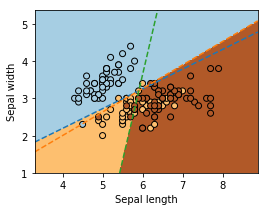

In [10]:
import matplotlib.pyplot as plt

def draw_border(clr, X, y, incx=1, incy=1):

    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - incx, X[:, 0].max() + incx
    y_min, y_max = X[:, 1].min() - incy, X[:, 1].max() + incy
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h))
    Z = clr.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    # Draw lines
    x1, x2 = xx.min(), xx.max()
    for i in range(0, clr.coef_.shape[0]):
        for j in range(i+1, clr.coef_.shape[0]):
            delta = clr.coef_[i] - clr.coef_[j]
            db = clr.intercept_[i] - clr.intercept_[j]
            y1 = (-db - delta[0] * x1) / delta[1]
            y2 = (-db - delta[0] * x2) / delta[1]
            ax.plot([x1, x2], [y1, y2], '--')
    
    return ax

draw_border(clr, X, y);

## Quelques diagramme de Voronoï

In [11]:
points = numpy.array([[1, 2], [3, 4], [4, 1]])

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

array([[1., 2.],
       [3., 4.],
       [4., 1.]])

c:\Python364_x64\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


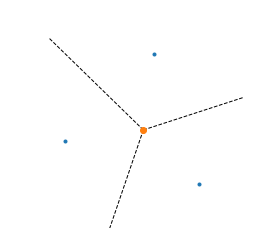

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.axis('off');

In [14]:
vor.point_region

array([2, 1, 0, 3], dtype=int64)

In [15]:
vor.vertices

array([[2.5       , 2.16666667],
       [3.9       , 3.1       ]])

c:\Python364_x64\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


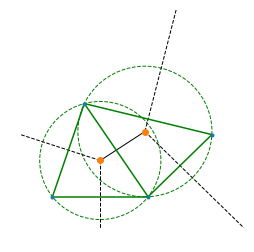

In [16]:
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
points = numpy.array([[1, 1], [2, 4], [4, 1], [6,3]])
vor = Voronoi(points)
fig, ax = plt.subplots(figsize=(4,4))
cs = []
for i in range(vor.vertices.shape[0]):
    v = vor.vertices[i, :]
    d = (v - points[2, :])
    r = (d.dot(d) ** 0.5)
    circle = Circle((v[0], v[1]), r, fill=False, ls='--', edgecolor='g', visible=True)
    ax.add_artist(circle)
for i in range(points.shape[0]):
    for j in range(i+1, points.shape[0]):
        if i == 0 and j == 3:
            continue
        ax.plot(points[[i, j], 0], points[[i, j], 1], "g-")
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.axis('off');

## Un diagramme de Voronoï proche

On applique la formule définie par [Régression logistique, diagramme de Voronoï, k-Means](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_ml/lr_voronoi.html).

In [17]:
import numpy
points = []
for i in range(0, clr.coef_.shape[0]):
    for j in range(i + 1, clr.coef_.shape[0]):
        li = clr.coef_[i, :]
        lj = clr.coef_[j, :]
        ni = li @ li.T
        nj = lj @ lj.T
        d = li - lj
        dn = d @ d.T
        alpha = - ni/2 - clr.intercept_[i] + nj/2 + clr.intercept_[j]
        alpha /= dn
        mid = (li + lj) / 2 + d * alpha
        points.append(mid.tolist())
points = numpy.array(points)
points

array([[-0.31817734, -0.09638214],
       [ 0.26359112, -0.35920186],
       [ 4.66141723, -2.53672766]])

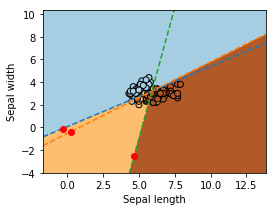

In [18]:
ax = draw_border(clr, X, y, incx=6, incy=6)
ax.plot(points[:, 0], points[:, 1], 'ro');

In [19]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
vor.points

array([[-0.31817734, -0.09638214],
       [ 0.26359112, -0.35920186],
       [ 4.66141723, -2.53672766]])

c:\Python364_x64\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


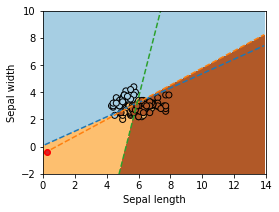

In [20]:
ax = draw_border(clr, X, y, incx=6, incy=6)
ax.plot(points[:, 0], points[:, 1], 'ro')
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([0, 14])
ax.set_ylim([-2, 10]);